## Project 2: Currency Predictor

### Prompt

*"Large companies often deal with foreign currency transactions while doing international business, and as a result, they are always looking for anything that can help them better understand the future direction and risk of various currencies. In this exercise, you will predict future movements in the value of the Japanese yen versus the U.S. dollar."*

### Approach

Overall, I'll take a first pass applying what I learn as I work through module 2, then follow up by comparing to public notebooks on Kaggle for gap analysis.

But first, we'll need to find the data. Luckily, [WSJ has historical prices for the USDJPY pair in a downloadable CSV](https://www.wsj.com/market-data/quotes/fx/USDJPY/historical-prices). I selected price data from December 2022 back to March 2006, which was the max range.

In [36]:
from numpy import float64
import pandas
data = pandas.read_csv('./data/USDJPY HistoricalPrices.csv',
                       names=['date', 'open', 'high', 'low', 'close'], header=0,
                       dtype={'open':float64, 'high':float64, 'low':float64, 'close':float64},
                       index_col='date', parse_dates=True,
                       engine='python')
data

,open,high,low,close
date,,,,
2022-12-30,133.02,133.09,130.78,131.12
2022-12-29,134.46,134.46,132.88,133.03
2022-12-28,133.50,134.50,133.38,134.48
2022-12-27,132.88,133.59,132.63,133.50
2022-12-26,132.76,133.24,132.31,132.88
...,...,...,...,...
2006-03-07,117.58,117.85,117.58,117.85
2006-03-06,116.38,117.58,116.38,117.58
2006-03-03,115.86,116.38,115.86,116.38


In [37]:
data.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [38]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,4393.0,105.269647,14.269503,75.83,96.81,107.94,113.89,150.14
high,4393.0,105.591571,14.366526,75.94,97.36,108.27,114.25,151.94
low,4393.0,104.926711,14.151276,75.83,96.36,107.63,113.48,149.56
close,4393.0,105.273337,14.274166,75.83,96.81,107.94,113.90,150.15


The data is sorted *new -> old*, but we need the opposite for trend analysis.

In [39]:
data = data.iloc[::-1] # reverse the curse
data

,open,high,low,close
date,,,,
2006-03-01,116.08,116.08,116.08,116.08
2006-03-02,116.08,116.08,115.86,115.86
2006-03-03,115.86,116.38,115.86,116.38
2006-03-06,116.38,117.58,116.38,117.58
2006-03-07,117.58,117.85,117.58,117.85
...,...,...,...,...
2022-12-26,132.76,133.24,132.31,132.88
2022-12-27,132.88,133.59,132.63,133.50
2022-12-28,133.50,134.50,133.38,134.48


Now we're ready to add a couple of indicators and chart it all out.

In [40]:
pandas.options.mode.chained_assignment = None # suppress SettingWithCopyWarning, default = 'warn'
data['change'] = data.close - data.open
data['pct'] = data.close.pct_change()
data['ma30'] = data.close.rolling(30).mean()
data['ma90'] = data.close.rolling(90).mean()
data

,open,high,low,close,change,pct,ma30,ma90
date,,,,,,,,
2006-03-01,116.08,116.08,116.08,116.08,0.00,NaN,NaN,NaN
2006-03-02,116.08,116.08,115.86,115.86,-0.22,-0.001895,NaN,NaN
2006-03-03,115.86,116.38,115.86,116.38,0.52,0.004488,NaN,NaN
2006-03-06,116.38,117.58,116.38,117.58,1.20,0.010311,NaN,NaN
2006-03-07,117.58,117.85,117.58,117.85,0.27,0.002296,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-26,132.76,133.24,132.31,132.88,0.12,0.000678,137.051333,141.847444
2022-12-27,132.88,133.59,132.63,133.50,0.62,0.004666,136.857667,141.811333
2022-12-28,133.50,134.50,133.38,134.48,0.98,0.007341,136.689000,141.781889


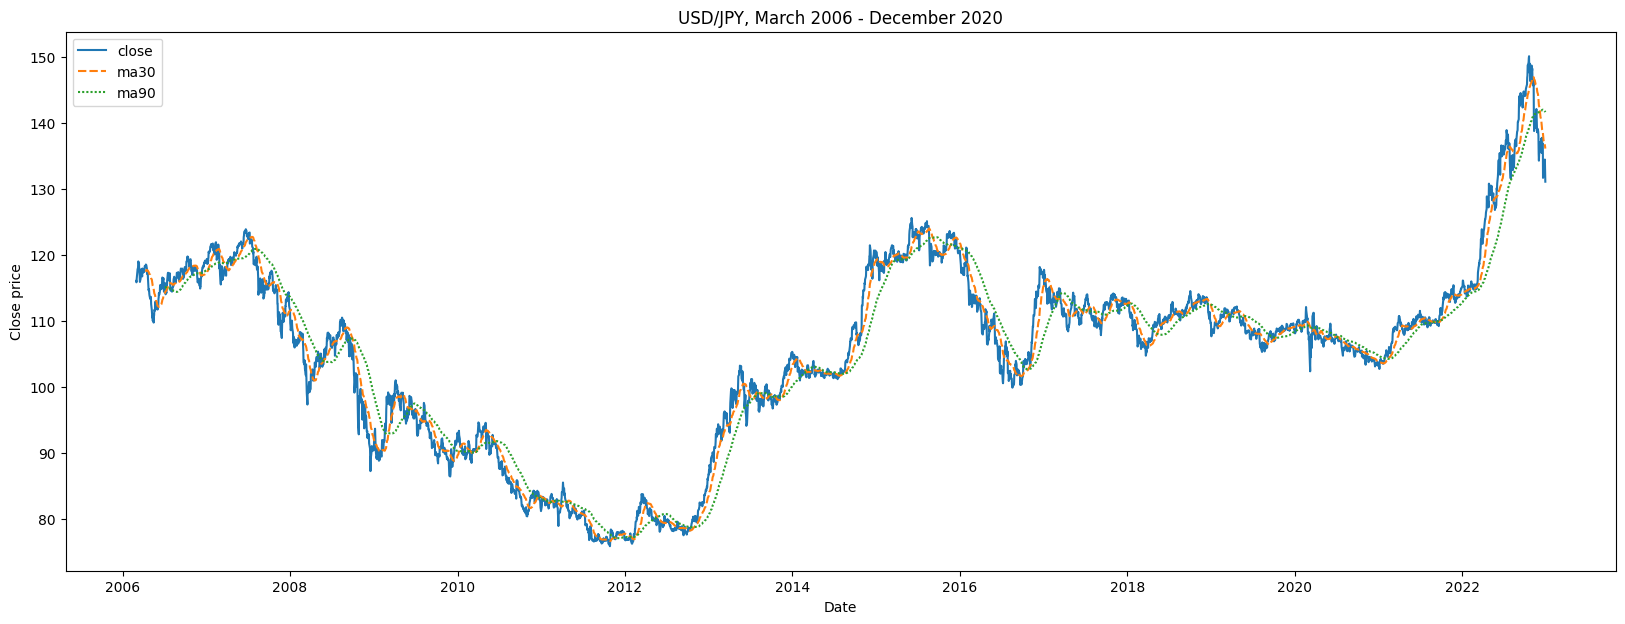

In [41]:
import matplotlib.pyplot as matplot
import seaborn
matplot.figure(figsize=(20, 7))
matplot.title('USD/JPY, March 2006 - December 2020')
seaborn.lineplot(data=data[['close', 'ma30', 'ma90']])
matplot.ylabel('Close price')
matplot.xlabel('Date')
pass # hide matplot.xlabel() output

Nothing surprising. Let's check for serial dependence.

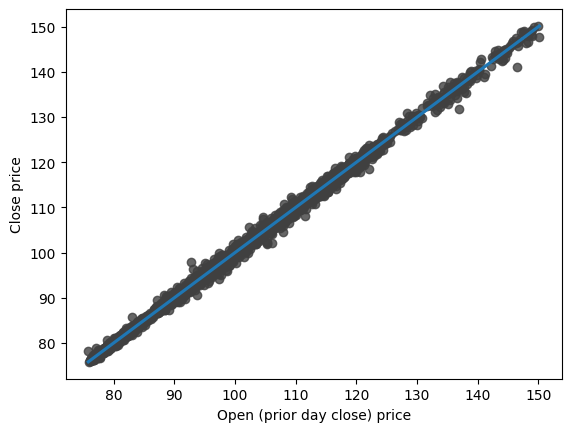

In [42]:
seaborn.regplot(data=data, x='open', y='close', scatter_kws={'color' : '0.25'}, ci=None) # ci=None used to skip confidence interval calculation
matplot.xlabel('Open (prior day close) price')
matplot.ylabel('Close price')
pass # hide seaborn.regplot() output

Yeah I'd say it's correlated. Even the outliers at the higher opening prices seem to line up with the most recent peaks.

The data's already pretty clean too, so we can cut straight to the linear regression model.

In [43]:
scrubbed = data.dropna()
scrubbed

,open,high,low,close,change,pct,ma30,ma90
date,,,,,,,,
2006-07-04,114.67,114.81,114.67,114.81,0.14,0.001221,114.245667,115.146778
2006-07-05,114.81,115.73,114.81,115.73,0.92,0.008013,114.338667,115.142889
2006-07-06,115.73,115.73,115.13,115.13,-0.60,-0.005184,114.450333,115.134778
2006-07-07,115.13,115.13,114.04,114.04,-1.09,-0.009468,114.497000,115.108778
2006-07-10,114.04,114.33,114.04,114.33,0.29,0.002543,114.559333,115.072667
...,...,...,...,...,...,...,...,...
2022-12-26,132.76,133.24,132.31,132.88,0.12,0.000678,137.051333,141.847444
2022-12-27,132.88,133.59,132.63,133.50,0.62,0.004666,136.857667,141.811333
2022-12-28,133.50,134.50,133.38,134.48,0.98,0.007341,136.689000,141.781889


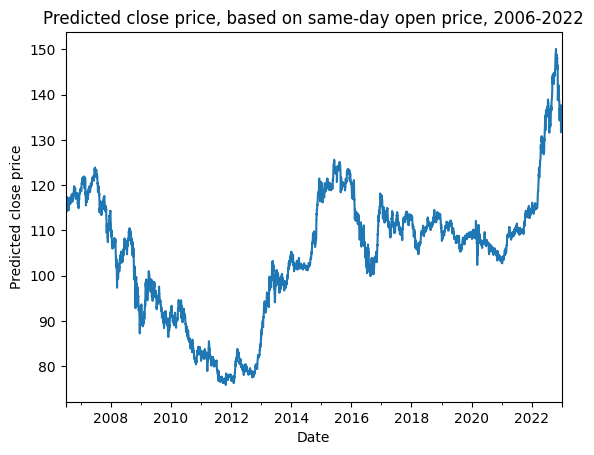

In [44]:
from sklearn.linear_model import LinearRegression
X = scrubbed.loc[:, ['open']]
y = scrubbed.close # "mUsT Be 1-diMEnSioNaL"
model = LinearRegression()
model.fit(X, y)
y_pred = pandas.Series(model.predict(X), index=X.index)
y_pred.plot()
matplot.title('Predicted close price, based on same-day open price, 2006-2022')
matplot.xlabel('Date')
matplot.ylabel('Predicted close price')
pass # you know the drill

That is almost certainly overfit, so let's pull some 2023 data and see if the model can predict that. 

WSJ only goes through 2022, but [MarketWatch](https://www.marketwatch.com/investing/currency/usdjpy/download-data) came in clutch. It's May at time of writing, so I've pulled price data for Q1 2023.

In [48]:
q1 = pandas.read_csv('./data/CURRENCY_US_XTUP_USDJPY.csv',
                       names=['date', 'open', 'high', 'low', 'close'], header=0,
                       dtype={'open':float64, 'high':float64, 'low':float64, 'close':float64},
                       index_col='date', parse_dates=True,
                       engine='python')
q1 = q1.iloc[::-1]
q1

,open,high,low,close
date,,,,
2023-01-02,131.12,131.12,130.63,130.74
2023-01-03,130.74,131.37,129.77,131.01
2023-01-04,131.03,132.73,129.94,132.63
2023-01-05,132.63,134.06,131.68,133.40
2023-01-06,133.41,134.76,132.00,132.11
...,...,...,...,...
2023-03-27,130.54,131.78,130.51,131.57
2023-03-28,131.57,131.61,130.41,130.88
2023-03-29,130.88,132.89,130.77,132.87


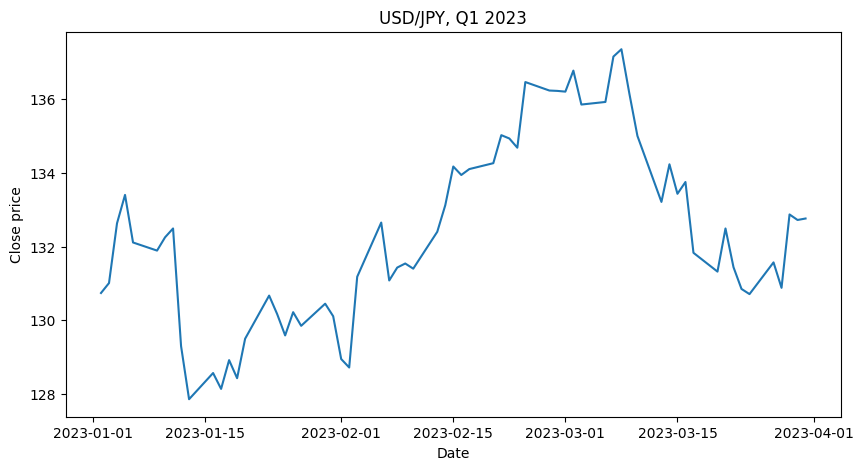

In [54]:
matplot.figure(figsize=(10, 5))
matplot.title('USD/JPY, Q1 2023')
seaborn.lineplot(data=q1.close)
matplot.ylabel('Close price')
matplot.xlabel('Date')
pass 

Good to go. But first, here's the whole thing just for fun.

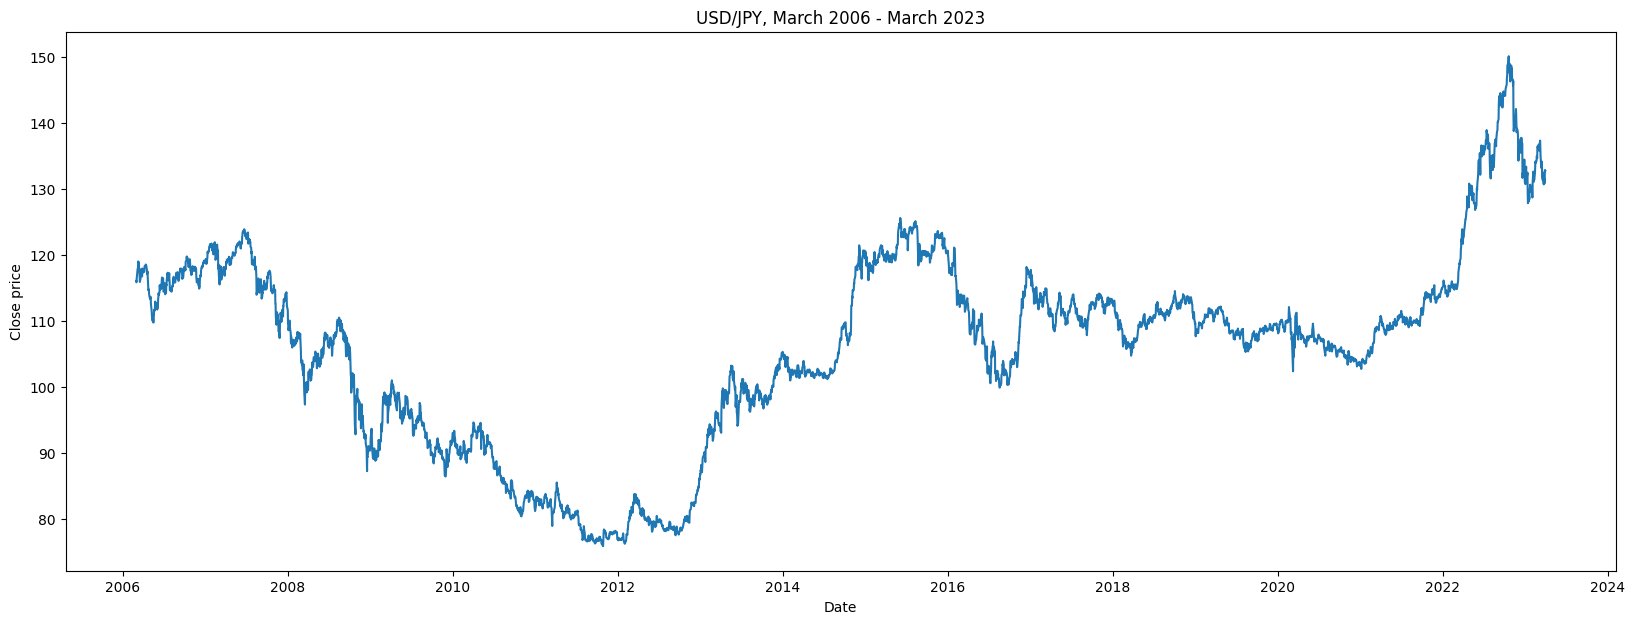

In [55]:
matplot.figure(figsize=(20, 7))
matplot.title('USD/JPY, March 2006 - March 2023')
seaborn.lineplot(data=pandas.concat([data.close, q1.close]).sort_index())
matplot.ylabel('Close price')
matplot.xlabel('Date')
pass

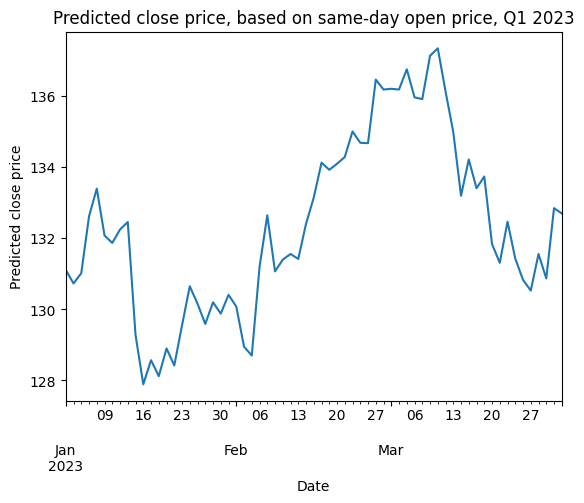

In [57]:
X_test = q1.dropna().loc[:, ['open']]
y_test = pandas.Series(model.predict(X_test), index=X_test.index)
y_test.plot()
matplot.title('Predicted close price, based on same-day open price, Q1 2023')
matplot.xlabel('Date')
matplot.ylabel('Predicted close price')
pass

Now lets compare the predicted to the actual for Q1.

In [62]:
comp = pandas.DataFrame({'predicted':y_test, 'actual':q1.close})
comp

,predicted,actual
date,,
2023-01-02,131.106223,130.74
2023-01-03,130.726483,131.01
2023-01-04,131.016284,132.63
2023-01-05,132.615187,133.40
2023-01-06,133.394652,132.11
...,...,...
2023-03-27,130.526621,131.57
2023-03-28,131.555914,130.88
2023-03-29,130.866387,132.87


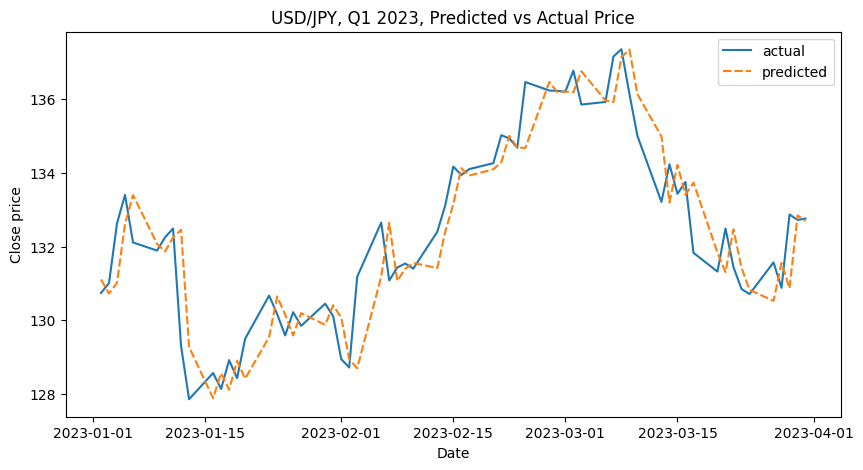

In [67]:
matplot.figure(figsize=(10, 5))
matplot.title('USD/JPY, Q1 2023, Predicted vs Actual Price')
seaborn.lineplot(data=comp.loc[:, ['actual', 'predicted']])
matplot.ylabel('Close price')
matplot.xlabel('Date')
pass # kilroy was here

Looks pretty slow, but considering this was trained on the 2006-2022 data it's not the worst.

Still, let's quantify how bad it is.

In [65]:
comp['error'] = comp.predicted - comp.actual
comp

,predicted,actual,error
date,,,
2023-01-02,131.106223,130.74,0.366223
2023-01-03,130.726483,131.01,-0.283517
2023-01-04,131.016284,132.63,-1.613716
2023-01-05,132.615187,133.40,-0.784813
2023-01-06,133.394652,132.11,1.284652
...,...,...,...
2023-03-27,130.526621,131.57,-1.043379
2023-03-28,131.555914,130.88,0.675914
2023-03-29,130.866387,132.87,-2.003613


In [70]:
comp.error.describe()

count    65.000000
mean     -0.040937
std       0.999729
min      -2.482124
25%      -0.714669
50%       0.002725
75%       0.476538
max       3.155297
Name: error, dtype: float64

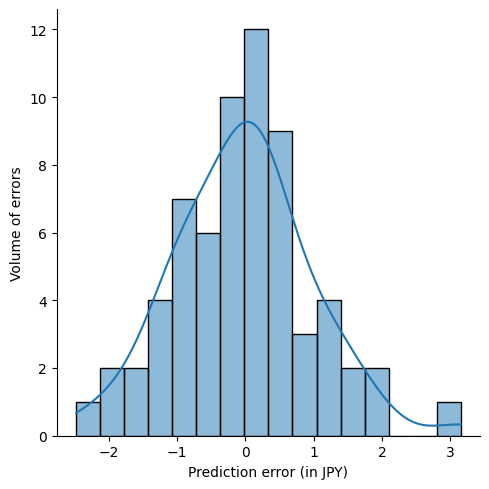

In [80]:
seaborn.displot(data=comp, x='error', kde=True, bins=16)
matplot.xlabel('Prediction error (in JPY)')
matplot.ylabel('Volume of errors')
pass 

Note that a higher error would correlate to higher losses (if entering a long position) as this indicates the model overpricing the close value for that day.